<a href="https://colab.research.google.com/github/IngyBadawi/naive-bayes/blob/main/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing necessary libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict
import argparse
import matplotlib.pyplot as plt
import random
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import math
from google.colab import files
import scipy.stats
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

##Importing the dataset

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1gWSJCngrtbQGSyqXnJUICjhCqNKyPwcd"})
downloaded.GetContentFile('archive.zip')        
!unzip -qq /content/archive.zip -d /content/dataset

##A function to extract the dataset

In [ ]:
rootdir = '/content/dataset'
def extract_data():
  D = np.empty((0,10304), int)
  Y = np.empty((0,1), int)
  for subdir, dirs, files in os.walk(rootdir):
      for file in files:
          if file.endswith(".pgm"):
            filepath = subdir + os.sep + file
            temp =cv2.imread(filepath, 0) 
            img = cv2.imread(filepath, 0).flatten()
            label = subdir[-2:]
            if label[0] == 's':
              label = label[1]
            D = np.vstack((D, img))
            Y = np.vstack((Y, int(label)))
  D = np.hstack((D, Y))
  D = D[D[:, 10304].argsort()]
  Y = D[:,10304:]
  D = D[:,:10304]
  return D, Y

##A function to split the dataset to training and testing data (50-50)

In [ ]:
def separate_data(D, Y):
  D_train = D[::2, :]
  Y_train = Y[::2, :]
  D_test = D[1::2, :]
  Y_test = Y[1::2, :]
  return D_train, Y_train, D_test, Y_test

##Utility functions

###A utility function to classify data according to their *label*

In [ ]:
def make_train_dict(D_train, Y_train):
  train = defaultdict(list)
  for i in range(len(Y_train)):
    train[int(Y_train[i])].append(D_train[i])
  return train

###Utility functions to get necessary info about the dataset

In [ ]:
def get_mean(feature):
  return sum(feature) / float(len(feature))

def get_std_dev(feature):
	avg = get_mean(feature)
	variance = sum([(x-avg)**2 for x in feature]) / float(len(feature))
	return math.sqrt(variance)

def get_dataset_info(dataset):
	info = [(get_mean(feature), get_std_dev(feature), len(feature)) for feature in zip(*dataset)]
	return info

##Train the model function

In [ ]:
def train_model(D_train, Y_train):
  separated_train = make_train_dict(D_train, Y_train)
  info = dict()
  for class_value, rows in separated_train.items():
    info[class_value] = get_dataset_info(rows)
  return info

##A function that calculates the probability of a certain data given the mean and standard deviation (Normal Distribution)

In [ ]:
def calculate_probability(x, mean, std_dev):
  exponent = math.exp(-((x-mean)**2 / (2 * std_dev**2 )))
  if std_dev == 0:
    std_dev = 0.0001
  return (1 / (math.sqrt(2 * math.pi) * std_dev)) * exponent

##A function that calculates the probability that a given data belongs to each class

In [ ]:
def calculate_class_probabilities(summaries, row):
  total_rows = sum([summaries[label][0][2] for label in summaries])
  probabilities = np.empty((40, 1), float)
  cnt = 0
  for class_value, class_summaries in summaries.items():
    probabilities[cnt] = float(summaries[class_value][0][2]/float(total_rows))
    hold = math.log(summaries[class_value][0][2]/(total_rows))
    for i in range(len(class_summaries)):
      mean, stdev, _ = class_summaries[i]
      curr_prob = calculate_probability(row[i], mean, stdev)
      if(curr_prob != 0):
        curr_prob = math.log(curr_prob)
      hold += curr_prob
    probabilities[cnt] = hold
    cnt += 1
  return probabilities

##Testing the model function

In [ ]:
def test_model(summary_train, D_test, Y_test):
  Y_pred = np.empty((0,1), int)
  correct = 0
  errors = []
  for i in range(len(D_test)):
    classes_probabilities = calculate_class_probabilities(summary_train, D_test[i])
    prediction = np.argmax(classes_probabilities) + 1
    Y_pred = np.vstack((Y_pred, prediction))
    if prediction == Y_test[i]:
      correct += 1
  acc = 100 * correct / (len(D_test))
  print("Accuracy: ", acc,"%")
  sns.set(rc={'figure.figsize':(15,10)})
  cnf_matrix = confusion_matrix(Y_test, Y_pred)
  ax = sns.heatmap(cnf_matrix,cmap="YlGnBu", annot=True)
  return Y_pred

##PCA

###A function to get the covariance matrix

In [ ]:
def get_covariance_matrix(data):
  my_df = pd.DataFrame(data)
  Z = my_df - my_df.mean().to_numpy()
  Zt = Z.transpose().to_numpy()
  n = my_df.count()
  my_cov = Zt @ Z
  my_cov = my_cov / n
  return my_cov

###A function to get the eigenvalues and eigenvectors

In [ ]:
def get_eigens(cov):
  eigenValues, eigenVectors = np.linalg.eigh(cov)
  idx = eigenValues.argsort()[::-1]   
  eigenValues = eigenValues[idx]
  eigenVectors = eigenVectors[:,idx]
  return eigenValues, eigenVectors

###A function to get the projection matrix given the number of dimensions needed

In [ ]:
def get_projection_matrix(e_values, e_vectors, n_of_dimensions = 40):
  projection_matrix = e_vectors[:, :n_of_dimensions]
  return np.array(projection_matrix)

###A utility function to reduce given data given the projection matrix

In [ ]:
def get_reduced_data(data, projection_matrix):
  reduced_data = data.dot(projection_matrix)
  return reduced_data

###Main PCA function that returns the reduced data

In [ ]:
def PCA(D_train, D_test):
  cov = get_covariance_matrix(D_train)
  eigenValues, eigenVectors = get_eigens(cov)
  p = get_projection_matrix(eigenValues, eigenVectors)

  reduced_train_data = get_reduced_data(D_train, p)
  reduced_test_data = get_reduced_data(D_test, p)

  return reduced_train_data, reduced_test_data

##Naive Bayes Function

In [ ]:
def naive_bayes(train_data, train_labels, test_data, test_labels):
  summary_train = train_model(train_data, train_labels)
  predictions = test_model(summary_train, test_data, test_labels)
  return predictions

In [ ]:
def show_image(index, title, predictions, D_test):
  predicted_img_label = predictions[index]
  predicted_img = D_test[5*predicted_img_label - 1]
  actual_img = D_test[index]
  actual_img_title = 'Actual person '
  if title[0] == 'C':
    actual_img_title += '(Same person)'
  else:
    actual_img_title += '(Not the same person)'
  fig = plt.figure()
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)
  ax1.title.set_text('Predicted Person')
  ax2.title.set_text(actual_img_title)
  ax1.imshow(np.reshape(predicted_img, (112, 92)), cmap=plt.get_cmap('gray'))
  ax2.imshow(np.reshape(actual_img, (112, 92)), cmap=plt.get_cmap('gray'))
  plt.suptitle(title)
  ax1.axis('off')
  ax1.grid(b=None)
  ax2.axis('off')
  ax2.grid(b=None)
  plt.show()
  plt.close()

In [ ]:
def show_cases(predictions, actual_labels, D_test, examples = 4):
  correct = 1
  false = 1
  mx = examples // 2
  counter = 0
  midtitle = ' classified image '
  for i in range(len(predictions)):
    finished = 1
    prefix = 'Correctly'
    if false < 0 and correct < 0:
      finished = 1
      break
    else:
      if false <= mx and predictions[i] != actual_labels[i]:
        prefix = 'Falsely'
        suffix = str(false)
        false += 1
        finished = 0
      elif correct <= mx and predictions[i] == actual_labels[i]:
        prefix = 'Correctly'
        suffix = str(correct)
        correct += 1
        finished = 0
    if finished == 0:
      title = prefix + midtitle + suffix
      show_image(i, title, predictions, D_test)

##Extracting the data and splitting them in order to be used

In [ ]:
D, Y = extract_data()
D_train, Y_train, D_test, Y_test = separate_data(D, Y)

##Calling the Naive Bayes function and comparing results

###Calling Naive Bayes function using all the data and all the features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Accuracy:  85.0 %


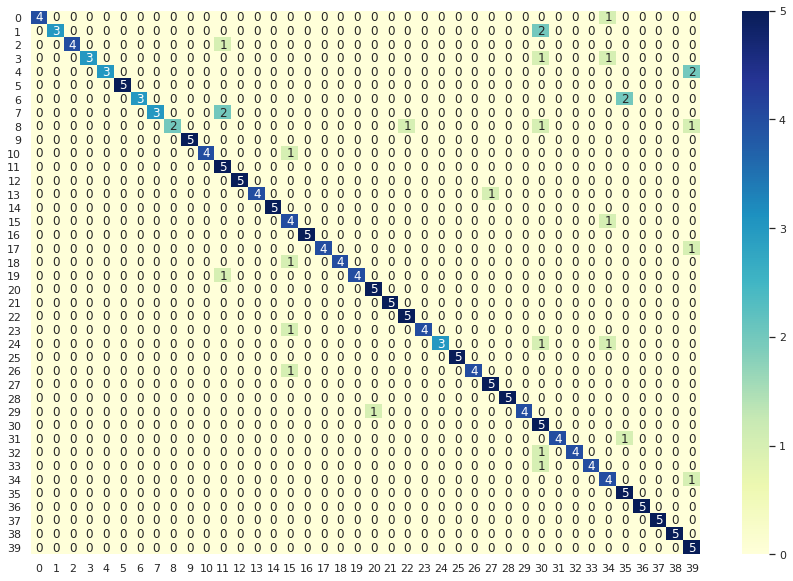

In [ ]:
normal_predictions = naive_bayes(D_train, Y_train, D_test, Y_test)

###Calling Naive Bayes function using the reduced data after performing PCA and taking only 40 dimensions instead of 10304 dimensions

Accuracy:  87.0 %


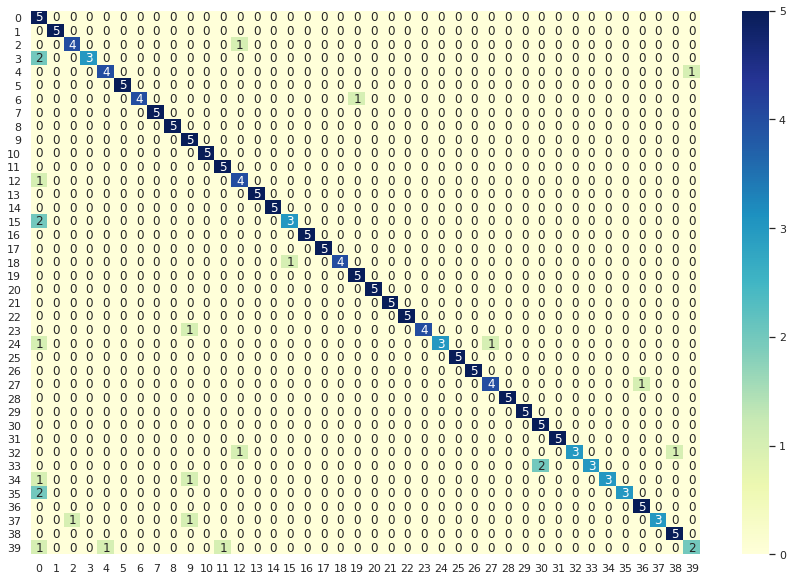

In [ ]:
reduced_train_data, reduced_test_data = PCA(D_train, D_test)
pca_predictions = naive_bayes(reduced_train_data, Y_train, reduced_test_data, Y_test)

##Showing correctly classified and misclassified faces against the correct faces

###When using all the 10304 dimensions

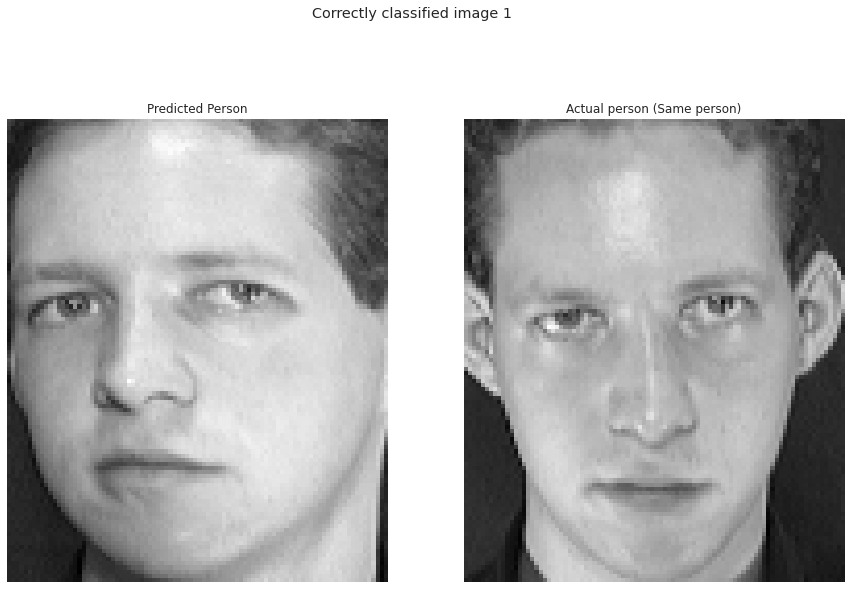

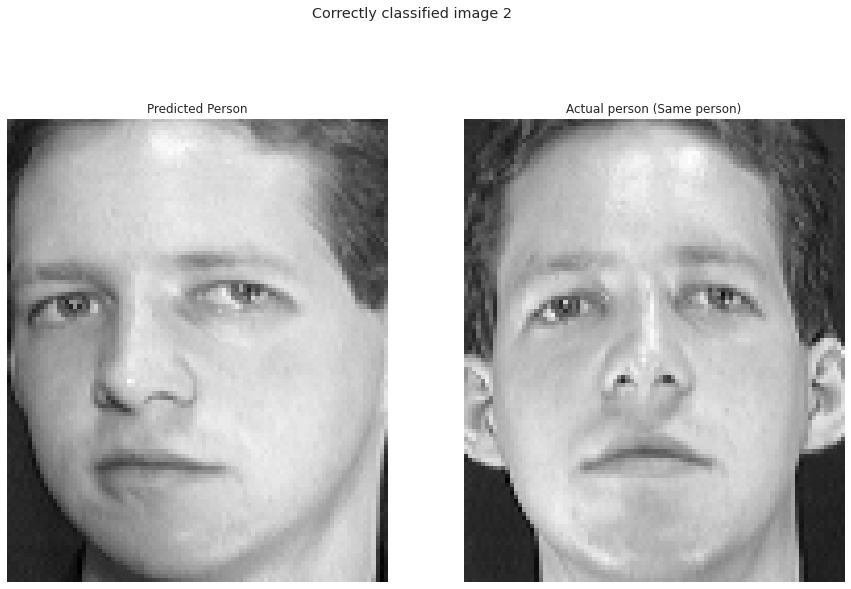

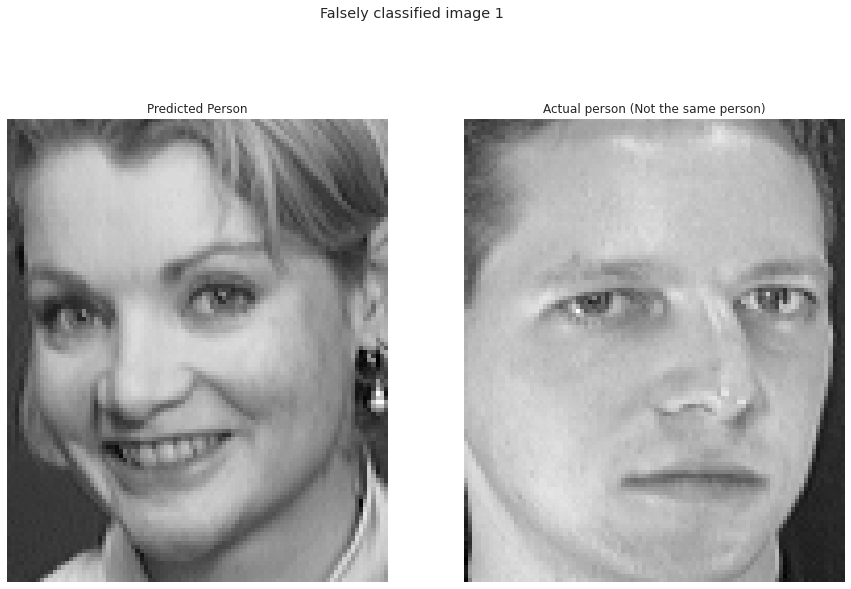

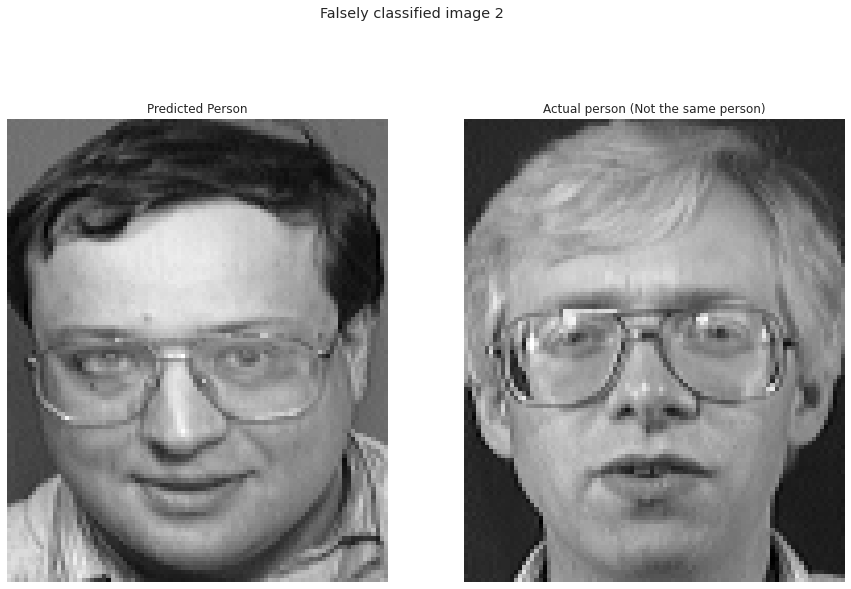

In [ ]:
show_cases(normal_predictions, Y_test, D_test)

###When using PCA for dimensionality reduction and using only 40 dimensions

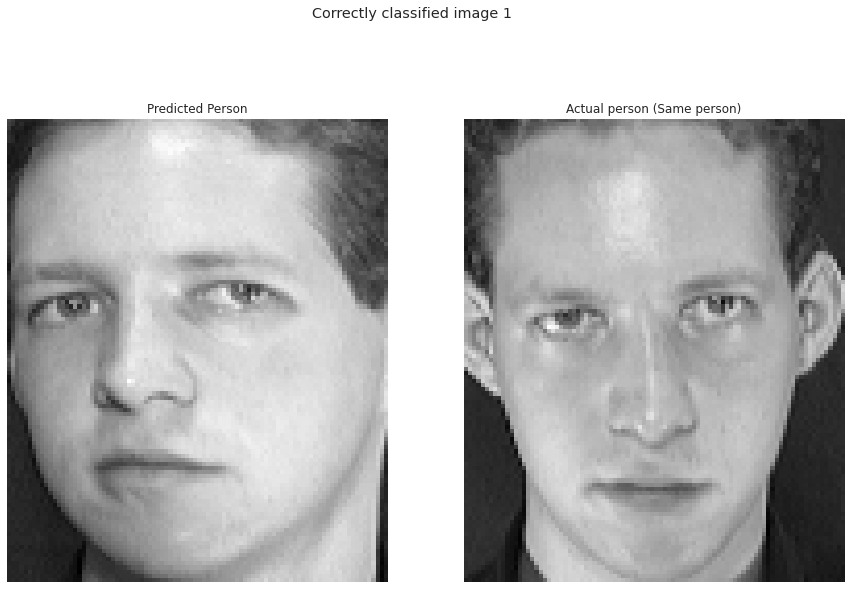

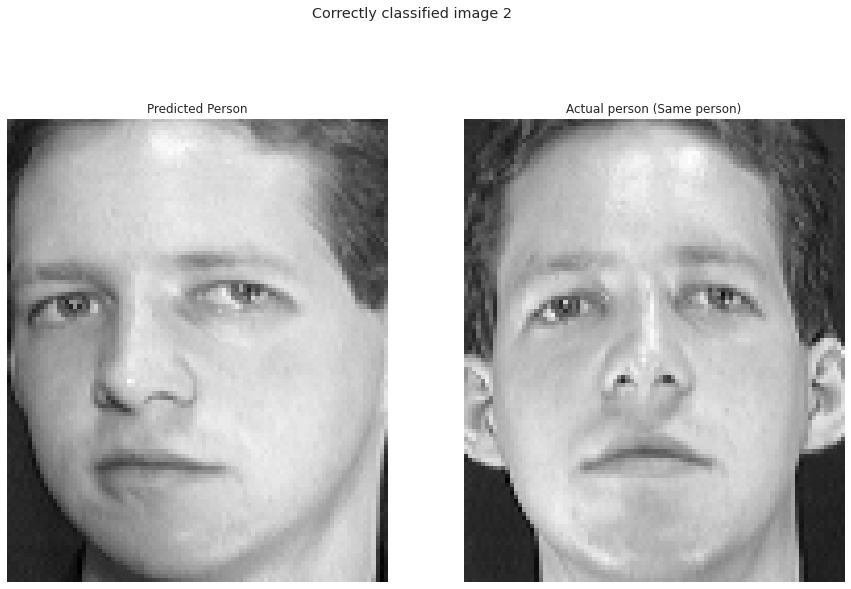

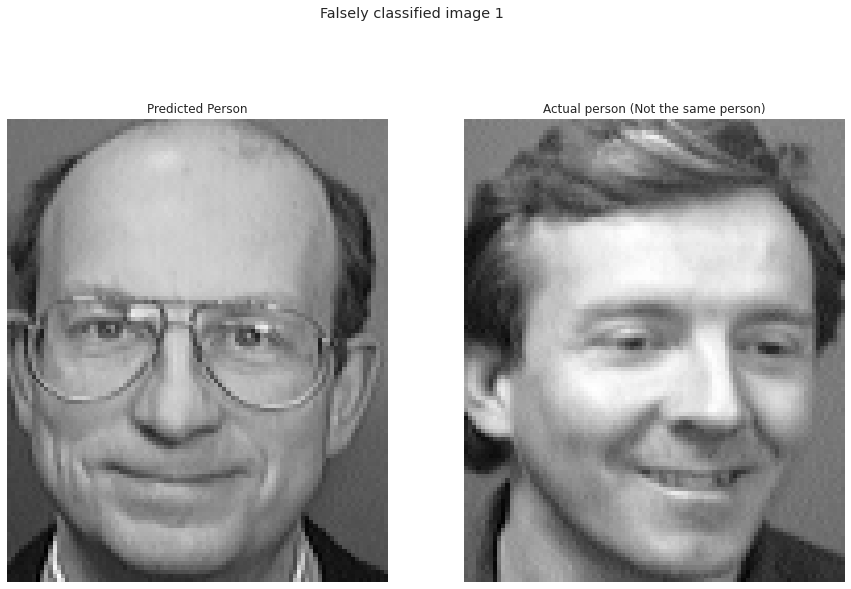

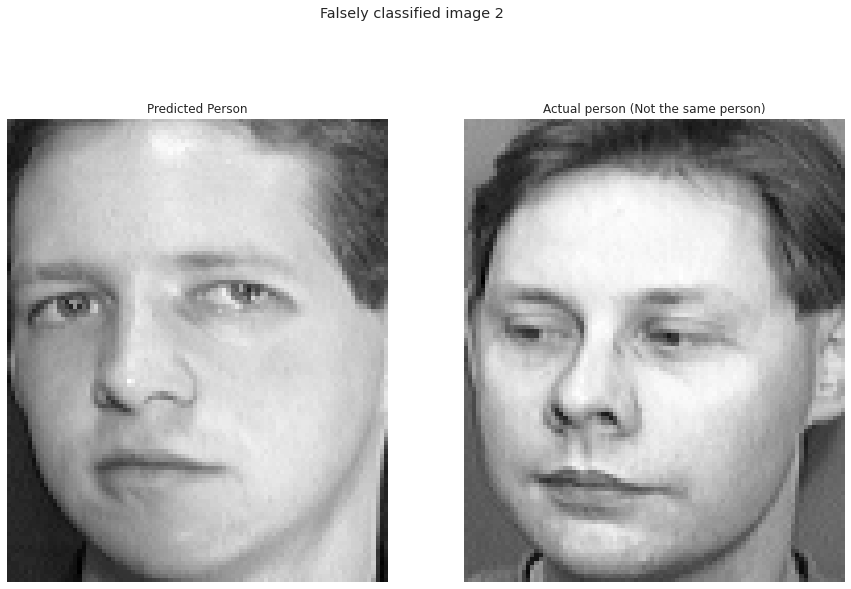

In [ ]:
show_cases(pca_predictions, Y_test, D_test)